In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
obulisainaren_multi_cancer_path = kagglehub.dataset_download('obulisainaren/multi-cancer')

print('Data source import complete.')


Data source import complete.


## Import Needed Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")


2025-04-05 02:35:39.498496: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 02:35:39.499015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 02:35:39.501692: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 02:35:39.508511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743816939.518328  565580 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743816939.52

# Read Data

In [3]:
data_dir='/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folder='Brain Cancer'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

In [4]:
df

,filepath,labels
0,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
1,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
2,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
3,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
4,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_tumor
...,...,...
14995,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin
14996,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin
14997,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin
14998,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,brain_menin


In [5]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']
count_fig=px.bar(count,x='labels',y='count',title='count of labels',text_auto=True)
count_fig.show()

## split Data

In [6]:
strat=df['labels']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [7]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(10500, 2)
(2250, 2)
(2250, 2)


In [8]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
count=px.bar(count_train,x='labels',y='count',title='count of labels per train_df',text_auto=True)
count.show()

In [ ]:
count

In [9]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig=px.bar(count_valid,x='labels',y='count',title='count of labels per valid_df',text_auto=True)
fig.show()

In [10]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig=px.bar(count_test,x='labels',y='count',title='count of labels per test_df',text_auto=True)
fig.show()

## Data Augmentation

In [11]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )
ts_gen=ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 10500 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.


## sample of Data

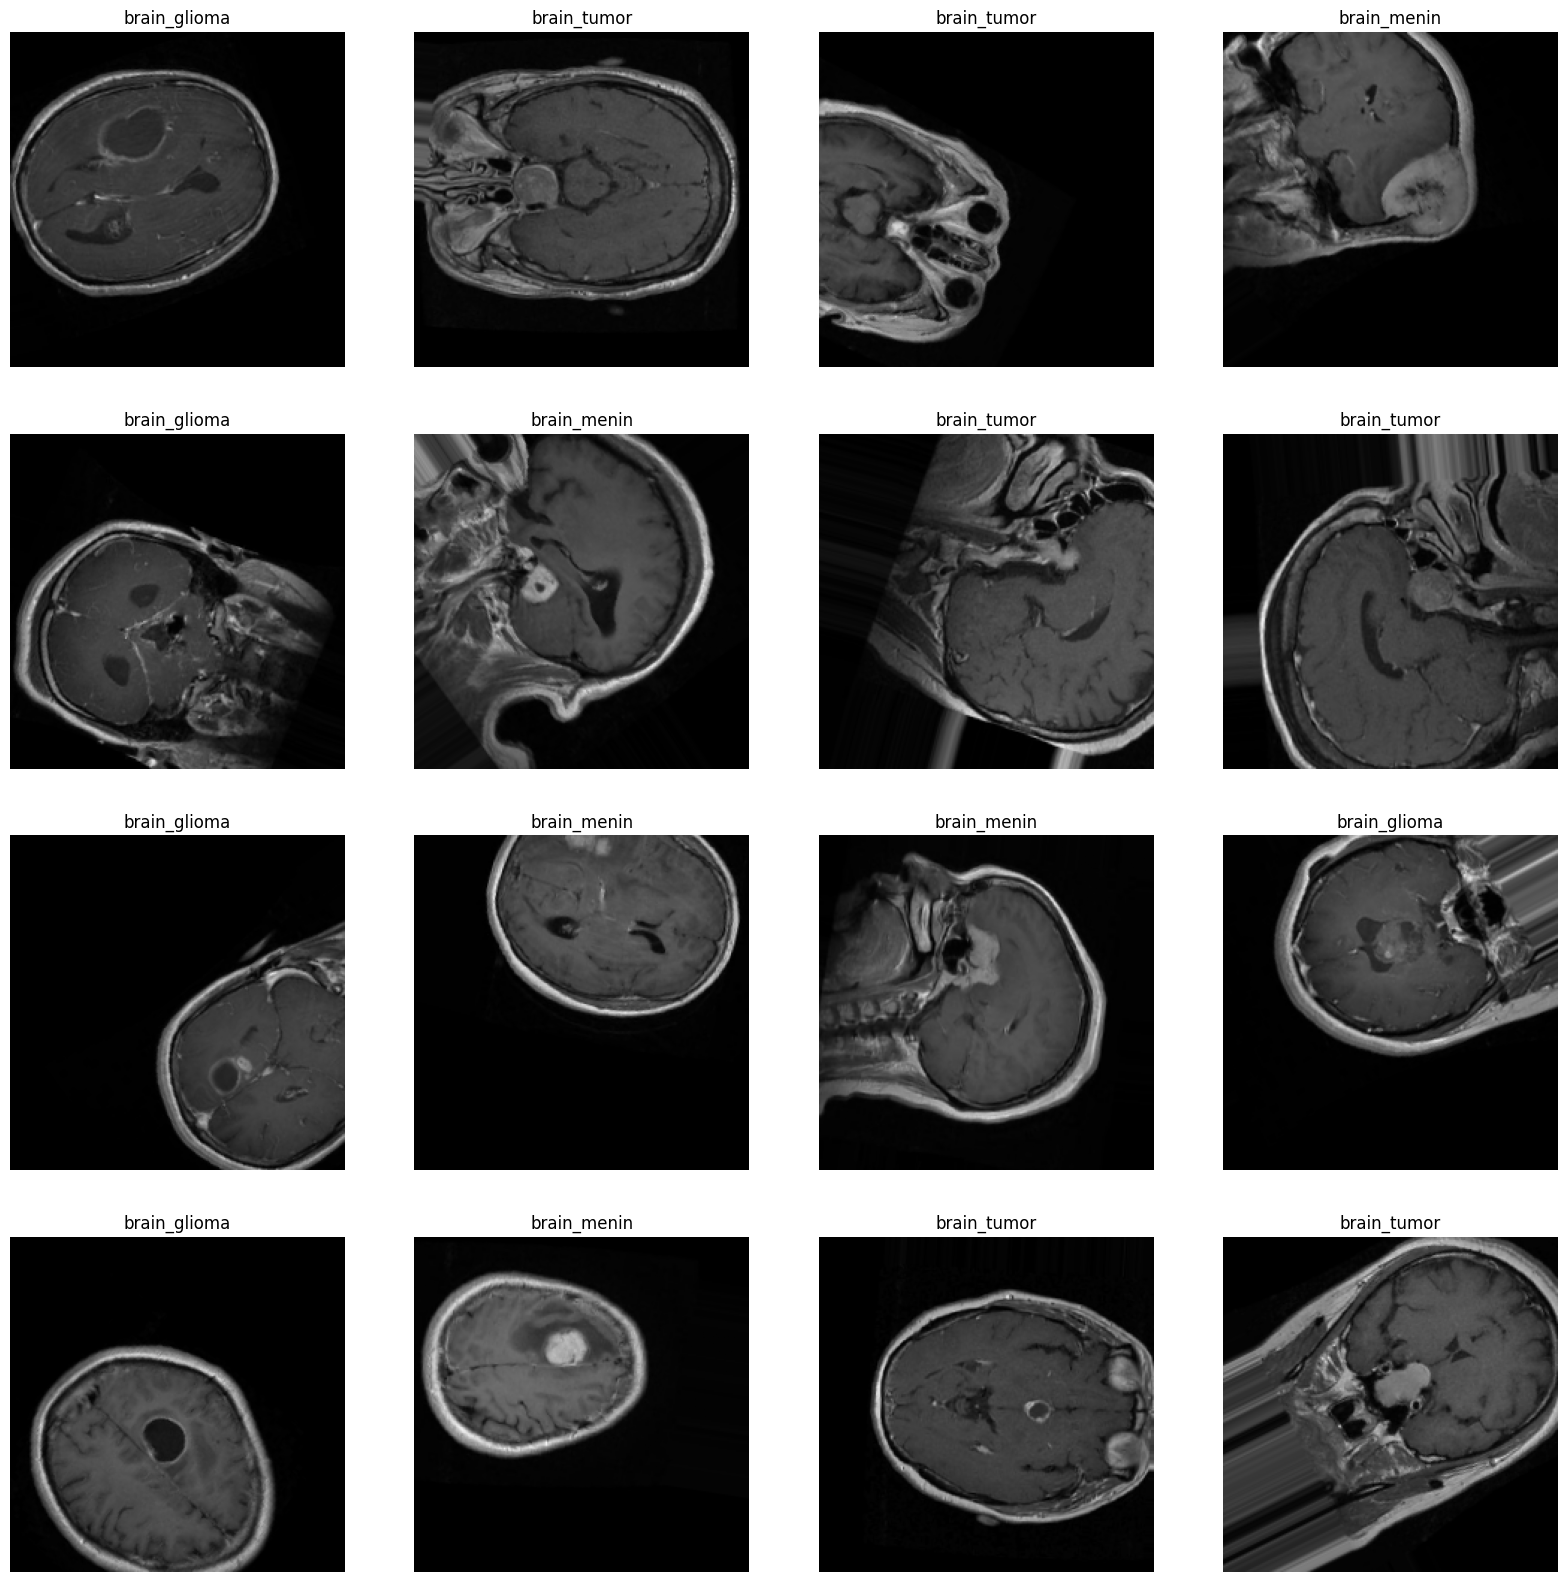

In [12]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

## Bulid model

In [13]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dense(3,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 20,097,407 (76.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.7778 - loss: 0.5689 - val_accuracy: 0.9507 - val_loss: 0.1589
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 163s 986ms/step - accuracy: 0.9317 - loss: 0.1849 - val_accuracy: 0.9427 - val_loss: 0.1626
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 164s 992ms/step - accuracy: 0.9475 - loss: 0.1436 - val_accuracy: 0.9413 - val_loss: 0.1590
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 164s 994ms/step - accuracy: 0.9608 - loss: 0.1081 - val_accuracy: 0.9613 - val_loss: 0.1062
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 202s 996ms/step - accuracy: 0.9700 - loss: 0.0813 - val_accuracy: 0.9484 - val_loss: 0.1374
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 165s 1000ms/step - accuracy: 0.9722 - loss: 0.0733 - val_accuracy: 0.9649 - val_loss: 0.0916
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9771 - loss: 0.0626 - val_accuracy: 0.9524 - val_loss: 0.1370
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 165s 994ms/step - accuracy: 0.978

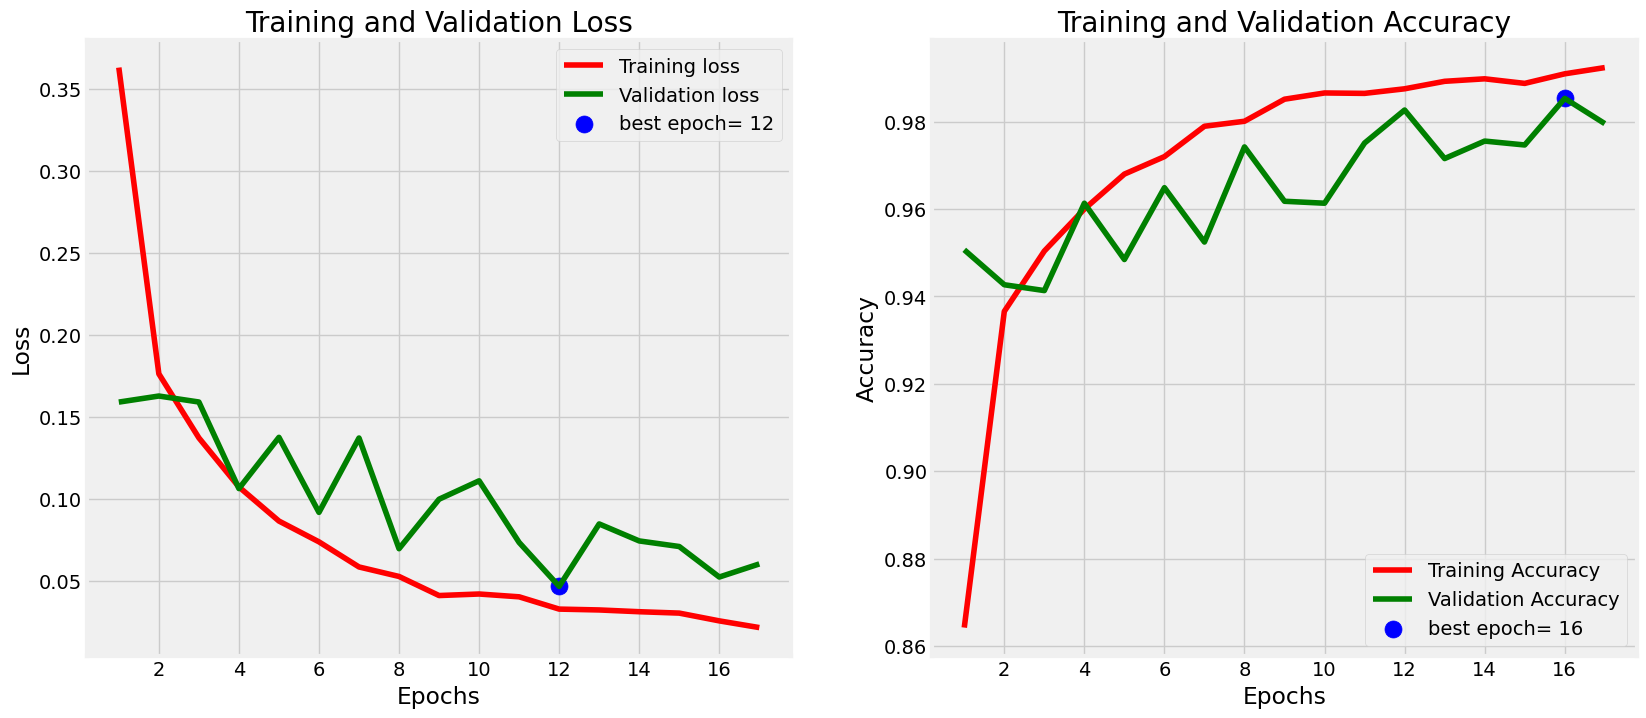

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evalution

In [17]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 859ms/step - accuracy: 0.9959 - loss: 0.0129
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.9897 - loss: 0.0338
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step - accuracy: 0.9804 - loss: 0.0476
Train Loss:  0.019594388082623482
Train Accuracy:  0.9927083253860474
--------------------
Valid Loss:  0.04613407328724861
Valid Accuracy:  0.9838541746139526
--------------------
Test Loss:  0.04714767262339592
Test Accuracy:  0.981249988079071


In [18]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step


## Confusion Matrix

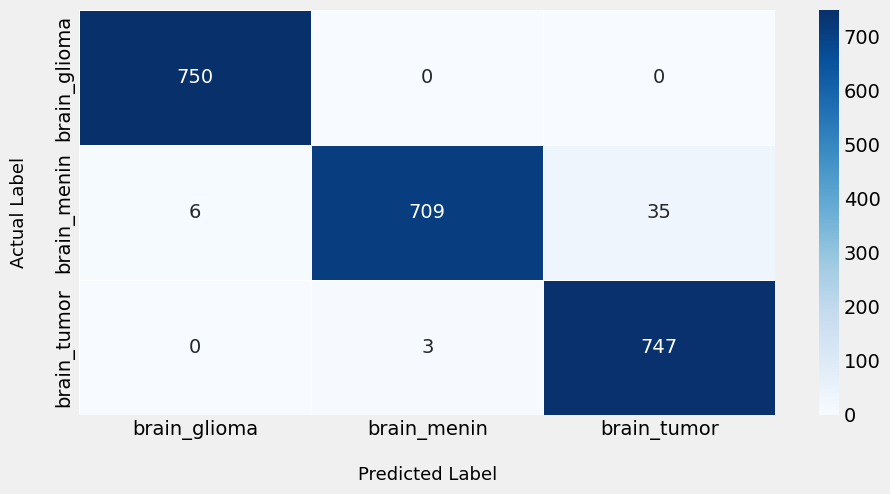

In [19]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

## classification Report

In [20]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

brain_glioma       0.99      1.00      1.00       750
 brain_menin       1.00      0.95      0.97       750
 brain_tumor       0.96      1.00      0.98       750

    accuracy                           0.98      2250
   macro avg       0.98      0.98      0.98      2250
weighted avg       0.98      0.98      0.98      2250



## save model

In [21]:
model.save('Brain tumor classification_edit.h5')

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
model.save('/content/drive/My Drive/Brain tumor classification_edit.h5')